# Milestone Project 1: Food Vision Big

Project Description Section...

### Check GPU

In order to use **mixed precision training**, we need access to a Tesla T4 GPU from within Google Coalb.

In [48]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  9 11:40:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |   2776MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import necessary libraries

In [99]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

import numpy as np
import pandas as pd

import datetime
import zipfile
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Getting helper functions ready

In [50]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-09 11:40:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-09 11:40:01 (104 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [51]:
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys

### Load TensorFlow dataset [**food101**](https://www.tensorflow.org/datasets/catalog/food101)

In [52]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=False, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

### Exploring data

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [53]:
# features of food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [54]:
# get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [55]:
# take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [56]:
# output info about our training sample
for image, label in train_one_sample:
  print(f'''
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  ''')


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [57]:
# what does our image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [58]:
# what are the min & max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

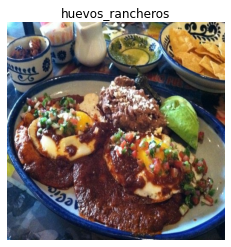

In [59]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Prepare the data for our model

Our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized *(not required for EfficientNetBX pretrained models)*

In [60]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  # image = image/255. # scaling (not required with EfficientNet pretrained models)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [61]:
# preprocess a single sample image & check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to (224, 224, 3).

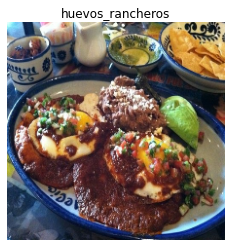

In [62]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

Before we can model our data, we have to turn it into batches.

For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

In [63]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

What we've just told TF to do:

* map this preprocessing function across our training dataset, 
* then shuffle a number of elements before batching them together and 
* make sure you prepare new batches (prefetch) whilst the model is looking through the current batch.

### Creating modelling callbacks

* Callbacks are a tool which can add helpful functionality to our models during training, evaluation or inference
* Some popular callbacks include: Tensorboard, Model checkpointing, Early stopping

In [65]:
# Create a model checkpoint callback to same the model's progress during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_accuracy doesn't improve for 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val accuracy metric
                                                  patience=4) # if val loss decreases for 4 epochs in a row, stop training

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


### Setup mixed precision training

Mixed precision utilizes a combination of `float32`and `float16` data types to speed up model performance.

In [66]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16')

### Build Feature Extraction Model

In [67]:
# create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [69]:
# check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [70]:
# check the dtype_policy attributes of the first 10 layers in our base model
for layer in base_model.layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


Note: A layer can have a dtype of `float32` and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

In [71]:
# fit the feature extraction model
initial_epochs = 8
history_1 = model.fit(train_data,
                      epochs=initial_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(len(test_data) * .33),
                      callbacks=[model_checkpoint,  
                                 create_tensorboard_callback(dir_name='final_project', 
                                                             experiment_name='feat_extr_model_1')])

Saving TensorBoard log files to: final_project/feat_extr_model_1/20210909-114004
Epoch 1/8


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 113s 45ms/step - loss: 1.8199 - accuracy: 0.5576 - val_loss: 1.2428 - val_accuracy: 0.6734
Epoch 2/8
2368/2368 [==============================] - 105s 44ms/step - loss: 1.2939 - accuracy: 0.6660 - val_loss: 1.1387 - val_accuracy: 0.6972
Epoch 3/8
2368/2368 [==============================] - 105s 44ms/step - loss: 1.1444 - accuracy: 0.7025 - val_loss: 1.0925 - val_accuracy: 0.7034
Epoch 4/8
2368/2368 [==============================] - 105s 44ms/step - loss: 1.0461 - accuracy: 0.7267 - val_loss: 1.0841 - val_accuracy: 0.7067
Epoch 5/8
2368/2368 [==============================] - 105s 44ms/step - loss: 0.9741 - accuracy: 0.7451 - val_loss: 1.0754 - val_accuracy: 0.7088
Epoch 6/8
2368/2368 [==============================] - 106s 44ms/step - loss: 0.9163 - accuracy: 0.7610 - val_loss: 1.0664 - val_accuracy: 0.7083
Epoch 7/8
2368/2368 [==============================] - 105s 44ms/step - loss: 0.8687 - accuracy: 0.7721 - val_loss: 1.0745 - val_accur

In [72]:
# evaluate model on whole test dataset
results_feat_extr_model = model.evaluate(test_data)

790/790 [==============================] - 28s 36ms/step - loss: 1.0845 - accuracy: 0.7079


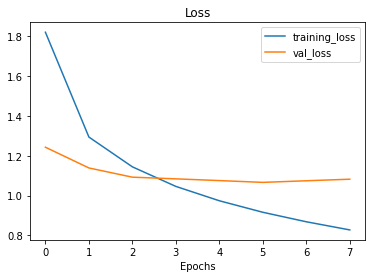

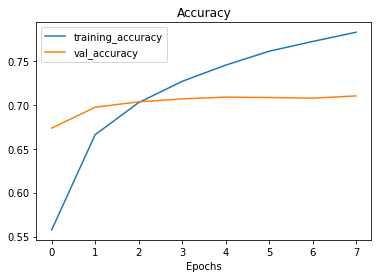

In [73]:
plot_loss_curves(history_1)

As we ca see, the training loss continues to drop whereas the validation loss stays unchanged beginning from the 2nd epoch. This is strong indication for **overfitting**. Let's now try to bring the loss curves closer together.

### Fine Tuning

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

In [74]:
# how many trainable variables in our base model?
print(len(model.layers[2].trainable_variables))

0


In [75]:
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [76]:
# to begin fine-tuning, let's start unfreeze all layers of our pretrained base model EfficientNetB0
base_model.trainable = True

In [77]:
# recompile 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(.0001), # we need to lower our lerning rate by 10x (rule of thumb) when fine tuning
              metrics=['accuracy'])

In [78]:
# check which layers are tunable (trainable)
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 rescaling_1 True
2 normalization_1 True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 b

In [79]:
# how many trainable layers does our model have now?
print(len(model.trainable_variables))

213


In [80]:
# create a checkpoint callback with a new directory path
checkpoint_path = "fine_tune_checkpoints/"
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [81]:
# fine tune the model
fine_tune_epochs = 100
history_2 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(.15 * len(test_data)),
                      initial_epoch=history_1.epoch[-1],
                      callbacks=[create_tensorboard_callback(dir_name='final_project', experiment_name='fine_tuning_model_2'),
                                 reduce_lr, early_stopping,
                                 fine_tune_model_checkpoint])

Saving TensorBoard log files to: final_project/fine_tuning_model_2/20210909-115445
Epoch 8/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 297s 121ms/step - loss: 0.7899 - accuracy: 0.7822 - val_loss: 0.9034 - val_accuracy: 0.7585
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
2368/2368 [==============================] - 283s 119ms/step - loss: 0.4571 - accuracy: 0.8719 - val_loss: 0.9274 - val_accuracy: 0.7595
Epoch 10/100
2368/2368 [==============================] - 283s 119ms/step - loss: 0.2454 - accuracy: 0.9295 - val_loss: 1.0696 - val_accuracy: 0.7500

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 11/100
2368/2368 [==============================] - 283s 119ms/step - loss: 0.0635 - accuracy: 0.9844 - val_loss: 1.1179 - val_accuracy: 0.7783
Epoch 12/100
2368/2368 [==============================] - 283s 119ms/step - loss: 0.0244 - accuracy: 0.9959 - val_loss: 1.2906 - val_accuracy: 0.7725

Epoch 00012: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.


### Evaluate the model

In [82]:
# evaluate model on whole test dataset
results_fine_tune_model = model.evaluate(test_data)

790/790 [==============================] - 28s 36ms/step - loss: 1.2621 - accuracy: 0.7769


Very well! Our fine-tuned model has managed to reach the validation accuracy score of 78%. 

Let's now check the classes which the model makes the most errors on.

In [84]:
# make predictions with our model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 26s 32ms/step


In [85]:
# the first 10 predictions
pred_probs[:10]

array([[1.3022531e-04, 8.0133724e-13, 1.6676180e-09, ..., 6.5206638e-07,
        2.7927347e-09, 5.0706597e-04],
       [8.9277696e-15, 1.2734778e-16, 2.9440657e-15, ..., 4.4448747e-16,
        8.7261670e-11, 7.1844706e-18],
       [6.5464214e-13, 5.4271740e-13, 3.2455952e-16, ..., 4.9697951e-14,
        4.0101689e-12, 6.1239889e-15],
       ...,
       [2.9863771e-11, 1.7683137e-15, 9.0316624e-16, ..., 2.2966387e-17,
        6.4410827e-17, 2.2931842e-14],
       [2.6890855e-20, 1.3656302e-19, 2.2739784e-18, ..., 6.5799753e-18,
        5.4615096e-10, 1.9869802e-19],
       [5.9551543e-01, 2.0237210e-09, 1.1176050e-09, ..., 1.0364096e-04,
        1.0635510e-14, 1.8592900e-01]], dtype=float32)

In [86]:
# get the pred classes of each label
pred_classes = pred_probs.argmax(1)

# how do they look
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  0])

In [94]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy()) # append the index which has the largest value (labels are not one-hot)

In [95]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7768712871287129

In [93]:
len(pred_classes)

25250

In [97]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

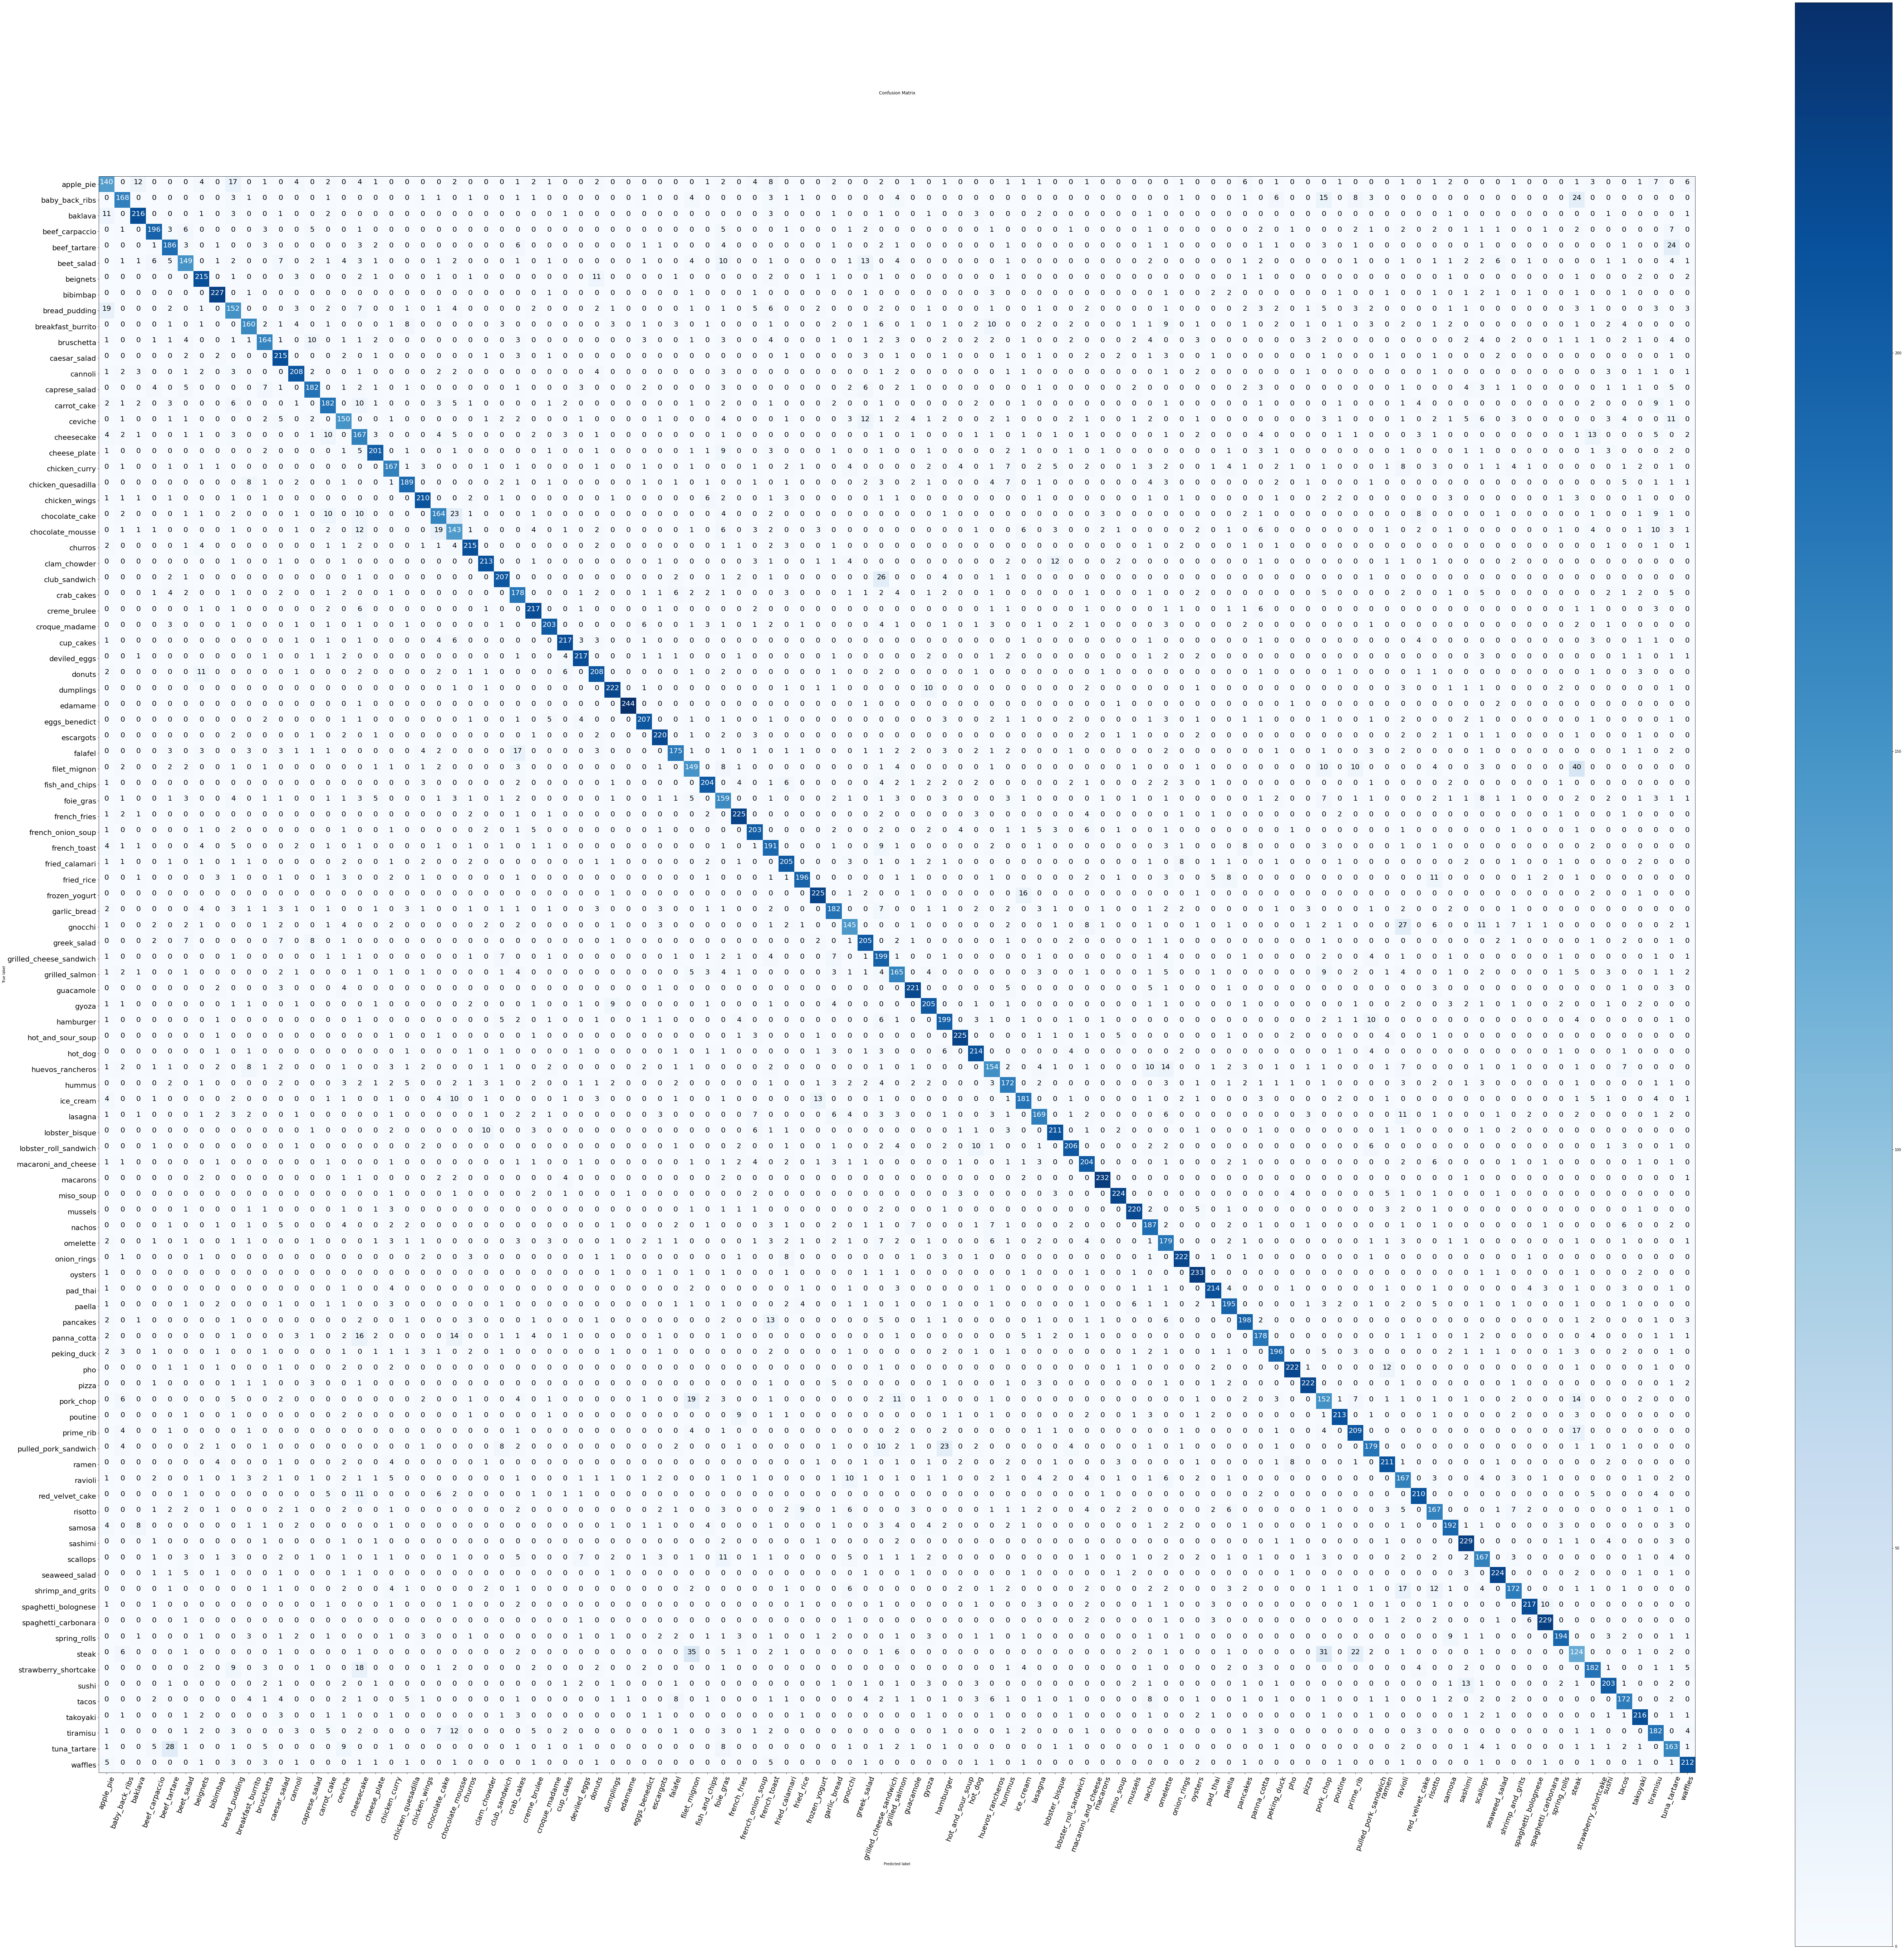

In [98]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

The majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting filet_mignon for instances of pork_chop and tuna_tartare for instances of beef_tartare.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [100]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       250
           1       0.77      0.67      0.72       250
           2       0.85      0.86      0.86       250
           3       0.84      0.78      0.81       250
           4       0.72      0.74      0.73       250
           5       0.70      0.60      0.64       250
           6       0.79      0.86      0.82       250
           7       0.88      0.91      0.89       250
           8       0.60      0.61      0.60       250
           9       0.78      0.64      0.70       250
          10       0.76      0.66      0.70       250
          11       0.75      0.86      0.80       250
          12       0.83      0.83      0.83       250
          13       0.81      0.73      0.77       250
          14       0.75      0.73      0.74       250
          15       0.65      0.60      0.62       250
          16       0.54      0.67      0.60       250
          17       0.86    

In [101]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.5821205821205822,
  'precision': 0.6060606060606061,
  'recall': 0.56,
  'support': 250},
 '1': {'f1-score': 0.7164179104477612,
  'precision': 0.7671232876712328,
  'recall': 0.672,
  'support': 250},
 '10': {'f1-score': 0.702355460385439,
  'precision': 0.7557603686635944,
  'recall': 0.656,
  'support': 250},
 '100': {'f1-score': 0.8346456692913387,
  'precision': 0.8217054263565892,
  'recall': 0.848,
  'support': 250},
 '11': {'f1-score': 0.8007448789571695,
  'precision': 0.7491289198606271,
  'recall': 0.86,
  'support': 250},
 '12': {'f1-score': 0.832,
  'precision': 0.832,
  'recall': 0.832,
  'support': 250},
 '13': {'f1-score': 0.7679324894514769,
  'precision': 0.8125,
  'recall': 0.728,
  'support': 250},
 '14': {'f1-score': 0.7383367139959431,
  'precision': 0.7489711934156379,
  'recall': 0.728,
  'support': 250},
 '15': {'f1-score': 0.6237006237006236,
  'precision': 0.6493506493506493,
  'recall': 0.6,
  'support': 250},
 '16': {'f1-score': 0.59856

In [102]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.5821205821205822,
 'baby_back_ribs': 0.7164179104477612,
 'baklava': 0.8588469184890656,
 'beef_carpaccio': 0.809917355371901,
 'beef_tartare': 0.730844793713163,
 'beet_salad': 0.6436285097192225,
 'beignets': 0.8221797323135754,
 'bibimbap': 0.8937007874015748,
 'bread_pudding': 0.601980198019802,
 'breakfast_burrito': 0.7048458149779736,
 'bruschetta': 0.702355460385439,
 'caesar_salad': 0.8007448789571695,
 'cannoli': 0.832,
 'caprese_salad': 0.7679324894514769,
 'carrot_cake': 0.7383367139959431,
 'ceviche': 0.6237006237006236,
 'cheese_plate': 0.8305785123966943,
 'cheesecake': 0.5985663082437276,
 'chicken_curry': 0.697286012526096,
 'chicken_quesadilla': 0.7974683544303797,
 'chicken_wings': 0.8484848484848485,
 'chocolate_cake': 0.681912681912682,
 'chocolate_mousse': 0.5731462925851704,
 'churros': 0.8651911468812877,
 'clam_chowder': 0.8658536585365854,
 'club_sandwich': 0.8329979879275654,
 'crab_cakes': 0.6872586872586872,
 'creme_brulee': 0.846003898635477

In [103]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.983871
63,macarons,0.937374
91,spaghetti_carbonara,0.916000
54,hot_and_sour_soup,0.912779
76,pizza,0.904277
...,...,...
39,foie_gras,0.584559
0,apple_pie,0.582121
22,chocolate_mousse,0.573146
77,pork_chop,0.572505


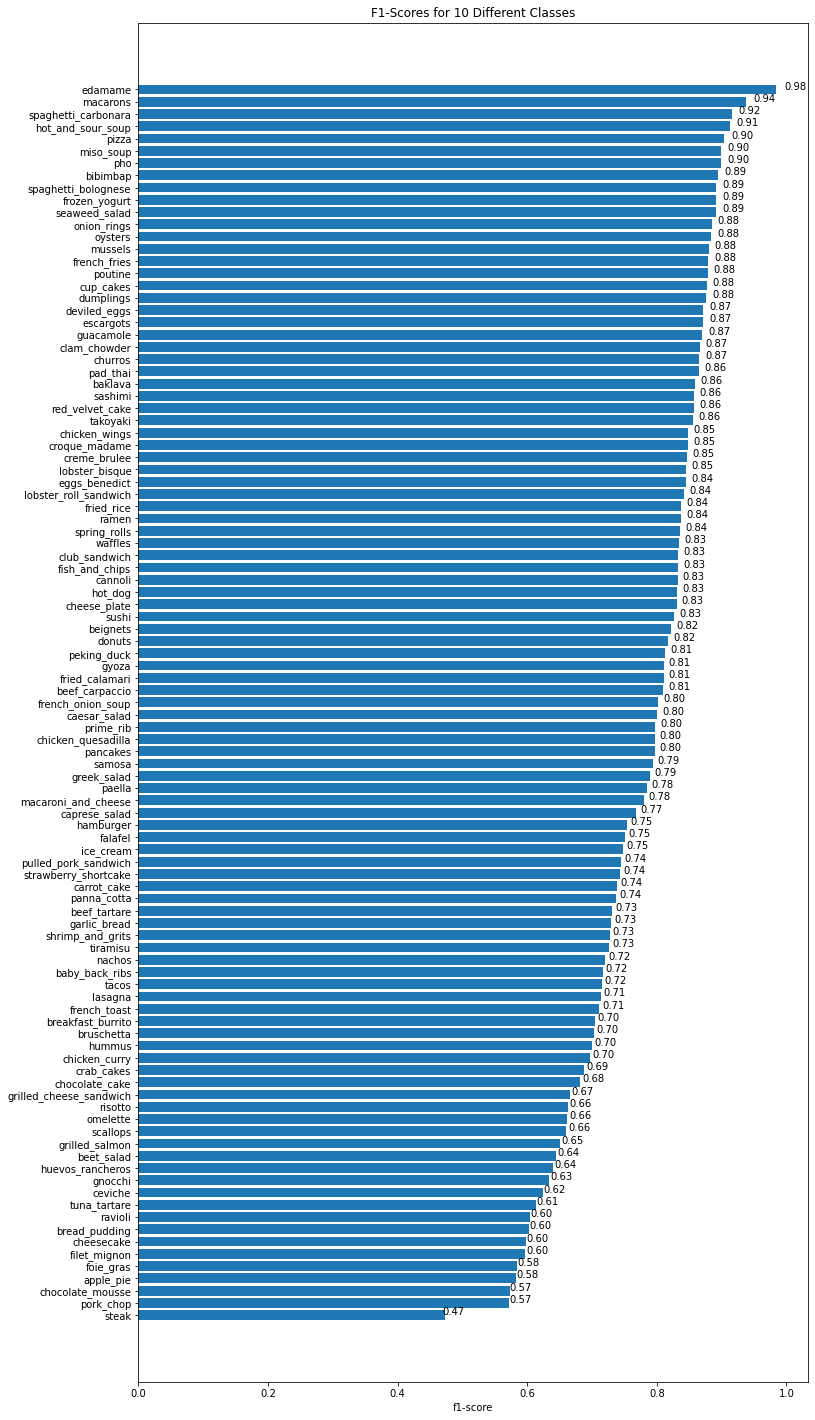

In [104]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

It seems like our model performs fairly poorly on classes like *steak*, *pork_chop* and *apple_pie* while for classes like *edamame* and *macarons* the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.